# Práctica 3: Tarea de regresión

In [2]:
%%capture
!pip install spacy
!pip install nltk
!pip install scikit-learn
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install folium

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import datetime
from IPython.display import display, IFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


# Analisis exploratorio

In [4]:
df = pd.read_csv('train_housing_data_italy.csv')
df_test = pd.read_csv('test_housing_data_italy.csv')
df.head()

,timestamp,location,title,price,n_rooms,floor,mq,n_bathrooms,year_of_construction,availability,...,has_balcony,has_fireplace,has_alarm,has_air_conditioning,has_pool,has_parking,has_elevator,is_furnished,latitude,longitude
0,1.661114e+09,siculiana,"villa unifamiliare via campo spoto 38, siculiana",46000.0,4.0,NaN,85.0,2.0,NaN,not free / other,...,0,0,0,0,0,0,0,0,37.338086,13.421996
1,1.661114e+09,strongoli,"quadrilocale contrada tronga 211, tronca, stro...",120000.0,4.0,2.0,190.0,2.0,NaN,not free / other,...,0,0,0,0,0,0,0,0,39.263959,17.052026
2,1.661114e+09,zelbio,"bilocale buono stato, piano terra, zelbio",55000.0,2.0,NaN,85.0,1.0,NaN,not free / other,...,0,1,0,1,0,0,0,0,45.904582,9.180539
3,1.661114e+09,villamagna,"casa colonica, da ristrutturare, 319 m², villa...",130000.0,4.0,NaN,319.0,1.0,NaN,not free / other,...,0,0,0,0,0,0,0,0,42.333295,14.236808
4,1.661114e+09,vallefiorita,"appartamento corso italia, vallefiorita",30000.0,NaN,NaN,143.0,2.0,NaN,not free / other,...,0,0,0,1,0,0,0,0,38.776385,16.461003


Columnas principales:

- Precio del terreno (price).
- Fecha de creacion del post y ano de contruccion (timestamp, year_of_contruction).
- Region de Italia y coordenadas (location, latitude, longitude).
- Numero de habitaciones, sanitarios (n_killed, n_injured).
- Indica en que piso esta la casa (floor)
- Acomodaciones (has_balcony, has_fireplace,...)
- Tamano del terreno/casa (mq)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213409 entries, 0 to 213408
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   timestamp             213409 non-null  float64
 1   location              213409 non-null  object 
 2   title                 213409 non-null  object 
 3   price                 175931 non-null  float64
 4   n_rooms               155561 non-null  float64
 5   floor                 144307 non-null  float64
 6   mq                    209520 non-null  float64
 7   n_bathrooms           199605 non-null  float64
 8   year_of_construction  213399 non-null  float64
 9   availability          213409 non-null  object 
 10  energy_class          212761 non-null  object 
 11  status                213409 non-null  object 
 12  heating               213409 non-null  object 
 13  has_garage            213409 non-null  int64  
 14  has_terrace           213409 non-null  int64  
 15  

Revisamos la cantidad de nulos

In [6]:
missing_data = df.isnull().sum()
print(missing_data)

timestamp                   0
location                    0
title                       0
price                   37478
n_rooms                 57848
floor                   69102
mq                       3889
n_bathrooms             13804
year_of_construction       10
availability                0
energy_class              648
status                      0
heating                     0
has_garage                  0
has_terrace                 0
has_garden                  0
has_balcony                 0
has_fireplace               0
has_alarm                   0
has_air_conditioning        0
has_pool                    0
has_parking                 0
has_elevator                0
is_furnished                0
latitude                   60
longitude                  60
dtype: int64


Revisamos las estadisticas de nuestras variables numericas

In [7]:
statistics = df[['price', 'n_rooms', 'floor', 'mq', 'n_bathrooms', 'year_of_construction']].describe()
print(statistics)

              price        n_rooms          floor             mq  \
count  1.759310e+05  155561.000000  144307.000000  209520.000000   
mean   2.413253e+05       3.503442       1.820466     158.692311   
std    7.739356e+06       0.985594       1.134597     128.708312   
min    1.000000e+00       2.000000       1.000000       1.000000   
25%    7.700000e+04       3.000000       1.000000      80.000000   
50%    1.350000e+05       3.000000       2.000000     118.000000   
75%    2.350000e+05       4.000000       2.000000     189.000000   
max    2.147484e+09       5.000000      52.000000     999.000000   

         n_bathrooms  year_of_construction  
count  199605.000000         213399.000000  
mean        1.587751           1965.096462  
std         0.668113             76.663750  
min         1.000000           1000.000000  
25%         1.000000           1960.000000  
50%         1.000000           1980.000000  
75%         2.000000           2000.000000  
max         3.000000       

Revisamos variables categoricas

In [8]:
unique_values1 = df['energy_class'].unique()
unique_values2 = df['location'].unique()
unique_values3 = df['heating'].unique()

print(unique_values1, unique_values2, unique_values3)

[nan 'a3' 'g' 'e' 'b' 'a' 'd' 'c' 'f' 'a1' 'a+' 'a4' 'a2'] ['siculiana' 'strongoli' 'zelbio' ... 'adelfia' 'alberobello' 'altamura'] ['autonomous' 'other']


# Limpieza de datos

Primero nos deshacemos de la mayoria de nulos.

Nos desharemos de algunas caracteristicas que realmente no parece que sean necesarias como title, floor.
Otras caracteristicas le cambiamos el data type para que sean compatibles para futuras funciones.

Tambien creamos algunas nuevas caracteristicas simples
- mq_price
- year_of_construction
- property_age

y otra que opino puede ser interesante analizar despues
- sustainability_score

In [9]:
cleaned_data = df

cleaned_data = cleaned_data.dropna(subset=['price', 'n_rooms','n_bathrooms', 'mq', 'year_of_construction', 'latitude', 'longitude', 'year_of_construction','energy_class', 'title']).copy()

# Convert 'n_rooms' and 'n_bathrooms' to integers and store in new columns using .loc
cleaned_data.loc[:, 'n_rooms_int'] = cleaned_data['n_rooms'].astype('Int64')
cleaned_data.loc[:, 'n_bathrooms_int'] = cleaned_data['n_bathrooms'].astype('Int64')


# Convert columns starting with 'has' or 'is' to boolean and store in new columns using .loc
bool_columns = [col for col in cleaned_data.columns if col.startswith('has') or col.startswith('is')]

for col in bool_columns:
    cleaned_data.loc[:, col + '_bool'] = cleaned_data[col].astype('boolean')

cleaned_data.loc[:, 'timestamp_dt'] = pd.to_datetime(cleaned_data['timestamp'], unit='s')

cleaned_data['title'] = cleaned_data['title'].str.lower()
cleaned_data = cleaned_data[~cleaned_data['title'].str.contains('terren')]


# Drop columns that we are not going to use
cleaned_data = cleaned_data.drop(columns=['title'])
cleaned_data = cleaned_data.drop(columns=['floor'])
cleaned_data = cleaned_data.drop(columns=['timestamp'])
cleaned_data = cleaned_data.drop(columns=['n_rooms','n_bathrooms'])
cleaned_data = cleaned_data.drop(columns=['heating'])
cleaned_data = cleaned_data.drop(columns=bool_columns)


# New Attributes
cleaned_data['mq_price'] = cleaned_data['price'] / cleaned_data['mq']
cleaned_data['year_of_construction'] = cleaned_data['year_of_construction'].fillna(datetime.datetime.now().year)
cleaned_data['property_age'] = datetime.datetime.now().year - cleaned_data['year_of_construction']

energy_class_scores = {
    'A++': 10,
    'A+': 9,
    'A': 8,
    'B': 7,
    'C': 6,
    'D': 5,
    'E': 4,
    'F': 3,
    'G': 2
}

def calculate_sustainability_score(row):
    # Energy class score
    energy_score = energy_class_scores.get(row['energy_class'].upper(), 0)
    
    # Property size penalty (larger properties may consume more energy)
    size_penalty = row['mq'] / 100 
    
    # Energy-intensive features penalty
    features_penalty = 0
    if row['has_air_conditioning_bool'] == 1:
        features_penalty += 1
    
    
    # Calculate total score
    sustainability_score = energy_score - (size_penalty + features_penalty)
    return sustainability_score

cleaned_data['sustainability_score'] = cleaned_data.apply(calculate_sustainability_score, axis=1)
cleaned_data.sort_values(by='sustainability_score', ascending=True).head()

,location,price,mq,year_of_construction,availability,energy_class,status,latitude,longitude,n_rooms_int,...,has_alarm_bool,has_air_conditioning_bool,has_pool_bool,has_parking_bool,has_elevator_bool,is_furnished_bool,timestamp_dt,mq_price,property_age,sustainability_score
152168,morrovalle,280000.0,925.0,1900.0,not free / other,a1,other,43.314553,13.579508,4,...,False,False,False,False,False,False,2022-08-22 05:08:46,302.702703,124.0,-9.25
173586,borgo san dalmazzo,580000.0,900.0,1978.0,not free / other,a2,other,44.328652,7.487456,4,...,False,False,False,False,False,True,2022-08-22 06:22:30,644.444444,46.0,-9.00
113227,cinisello balsamo,700000.0,995.0,1992.0,not free / other,g,other,45.558645,9.214196,2,...,False,True,False,False,False,False,2022-08-22 02:54:23,703.517588,32.0,-8.95
108185,carmignano,299000.0,995.0,1980.0,not free / other,g,other,43.814065,11.019030,4,...,False,True,False,False,True,False,2022-08-22 02:37:36,300.502513,44.0,-8.95
131840,cavriana,695000.0,857.0,2010.0,not free / other,a1,other,45.351335,10.600791,4,...,False,False,False,False,False,False,2022-08-22 03:57:05,810.968495,14.0,-8.57


Aplico unos filtros a las variables
- Primero me deshago de todos los registros donde los metros cuadrados sean menores a catorce porque no son correctos dado que en italia para poder vender o rentar un a casa se necesita que cuente con almenos 14 metros cuadrados para ser legal.
- Nos deshacemos de la parte mas baja de precios, y los outliers mas extremos.
- Tambien nos deshacemos de otros record donde la fecha de construccion se mayor a la actualidad

In [10]:
# First, let's remove entries with price of 0 from the original dataframe
cleaned_data = cleaned_data[cleaned_data['mq'] >= 14]
cleaned_data = cleaned_data[cleaned_data['price'] > 100]
cleaned_data = cleaned_data[cleaned_data['year_of_construction'] <= datetime.datetime.now().year]

# Now, for the top 100, let's remove the outliers by applying the IQR method again
Q1 = cleaned_data['price'].quantile(0.25)
Q3 = cleaned_data['price'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper bound for outliers (we don't need to apply the lower bound, as 0 prices are already removed)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR * 3
print(lower_bound)
print(upper_bound)

# Filter out outliers from the top 100 prices in the dataset
cleaned_data = cleaned_data[(cleaned_data['price'] <= upper_bound) & (cleaned_data['price'] >= lower_bound)]#.sort_values(by='price', ascending=False)

-110000.0
730000.0


Arreglamos los datos de test para que esten en el mismo formato, no los alteramos de ninguna otra forma

In [11]:
# Convetir data types
df_test.loc[:, 'n_rooms_int'] = df_test['n_rooms'].astype('Int64')
df_test.loc[:, 'n_bathrooms_int'] = df_test['n_bathrooms'].astype('Int64')
bool_columns = [col for col in df_test.columns if col.startswith('has') or col.startswith('is')]

for col in bool_columns:
    df_test.loc[:, col + '_bool'] = df_test[col].astype('boolean')
    
df_test.loc[:, 'timestamp_dt'] = pd.to_datetime(df_test['timestamp'], unit='s')

# Drop columns that we are not going to use
df_test = df_test.drop(columns=['title'])
df_test = df_test.drop(columns=['floor'])
df_test = df_test.drop(columns=bool_columns)
df_test = df_test.drop(columns=['timestamp'])
df_test = df_test.drop(columns=['n_rooms','n_bathrooms'])

df_test = df_test.dropna(subset=['price','mq','n_rooms_int','n_bathrooms_int','year_of_construction', 'latitude', 'longitude', 'energy_class']).copy()

# New Attributes
df_test['mq_price'] = df_test['price'] / df_test['mq']
df_test['year_of_construction'] = df_test['year_of_construction'].fillna(datetime.datetime.now().year)
df_test['property_age'] = datetime.datetime.now().year - df_test['year_of_construction']
df_test['sustainability_score'] = df_test.apply(calculate_sustainability_score, axis=1)

df_test.head()

,location,price,mq,year_of_construction,availability,energy_class,status,heating,latitude,longitude,...,has_alarm_bool,has_air_conditioning_bool,has_pool_bool,has_parking_bool,has_elevator_bool,is_furnished_bool,timestamp_dt,mq_price,property_age,sustainability_score
0,caravino,95000.0,190.0,1967.0,not free / other,g,other,autonomous,45.398258,7.960322,...,False,True,False,False,False,False,2022-08-21 22:39:28,500.000000,57.0,-0.90
1,valbrona,99000.0,80.0,1970.0,not free / other,e,other,autonomous,45.881055,9.301631,...,False,True,False,False,False,False,2022-08-21 21:10:11,1237.500000,54.0,2.20
2,altavilla vicentina,135000.0,210.0,1965.0,not free / other,g,other,autonomous,45.508429,11.470686,...,False,True,False,False,False,True,2022-08-21 21:57:56,642.857143,59.0,-1.10
3,san giovanni lupatoto,180000.0,90.0,2005.0,not free / other,g,other,autonomous,45.381968,11.044886,...,False,False,False,False,False,False,2022-08-21 22:01:47,2000.000000,19.0,1.10
5,sedegliano,95000.0,128.0,1930.0,not free / other,f,other,autonomous,46.014371,12.977430,...,False,True,False,False,False,False,2022-08-21 23:10:49,742.187500,94.0,0.72


Aqui creo una nueva caracteristica apartir de los datos boleanos, usamos un modelo de regresion lineal para calcular el peso de cada uno de las columnas sobre el precio. Luego con estos pesos hacemos un calculo por cada elemento y lo guardamos en added_commodity_weight.

                      Feature        Weight
7               has_pool_bool  92893.985770
5              has_alarm_bool  62656.525787
2             has_garden_bool  39132.690856
1            has_terrace_bool  20244.471839
0             has_garage_bool  11605.962811
9           has_elevator_bool   7437.473219
10          is_furnished_bool   1006.500565
6   has_air_conditioning_bool   -421.978222
4          has_fireplace_bool -12670.510942
3            has_balcony_bool -18937.481927
8            has_parking_bool -19032.097143


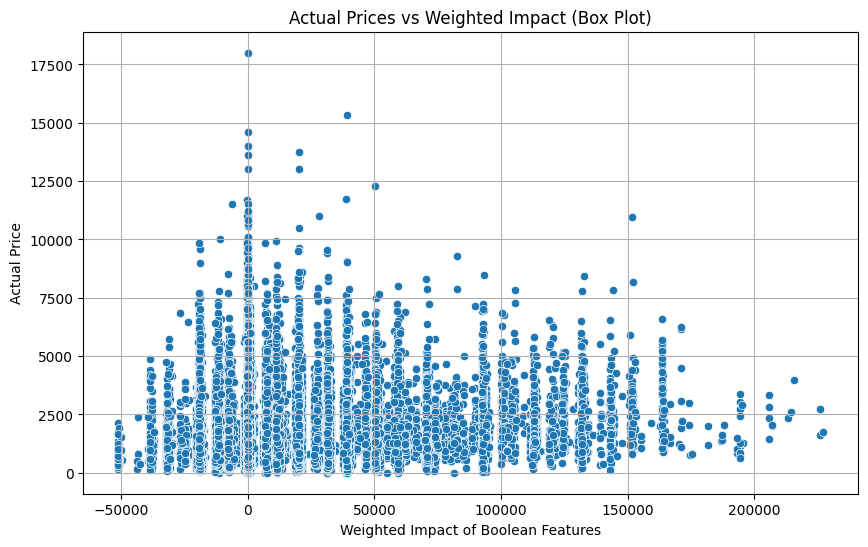

,location,price,mq,year_of_construction,availability,energy_class,status,latitude,longitude,n_rooms_int,...,has_air_conditioning_bool,has_pool_bool,has_parking_bool,has_elevator_bool,is_furnished_bool,timestamp_dt,mq_price,property_age,sustainability_score,added_commodity_weight
10,zumpano,90000.0,124.0,2002.0,not free / other,e,other,39.310894,16.292094,5,...,False,False,False,False,True,2022-08-21 20:34:42,725.806452,22.0,2.76,1006.500565
13,zumpano,59000.0,127.0,2001.0,not free / other,d,other,39.310894,16.292094,4,...,True,False,False,True,False,2022-08-21 20:34:43,464.566929,23.0,2.73,-5655.015945
15,zafferana etnea,65000.0,45.0,1950.0,not free / other,g,other,37.693285,15.106460,2,...,False,False,False,False,False,2022-08-21 20:34:43,1444.444444,74.0,1.55,0.0
16,zafferana etnea,120000.0,45.0,1900.0,not free / other,g,other,37.693285,15.106460,2,...,False,False,True,False,False,2022-08-21 20:34:43,2666.666667,124.0,1.55,-31702.608084
17,vinchiaturo,22000.0,70.0,1900.0,not free / other,g,other,41.492925,14.590729,2,...,False,False,False,False,False,2022-08-21 20:34:43,314.285714,124.0,1.30,0.0


In [12]:
# Step 1: Select the boolean features and the target (price)
boolean_columns = ['has_garage_bool', 'has_terrace_bool', 'has_garden_bool', 'has_balcony_bool', 
                   'has_fireplace_bool', 'has_alarm_bool', 'has_air_conditioning_bool', 
                   'has_pool_bool', 'has_parking_bool', 'has_elevator_bool', 'is_furnished_bool']

housing_data_cleaned = cleaned_data.dropna(subset=boolean_columns + ['mq_price'])

X = housing_data_cleaned[boolean_columns]
y = housing_data_cleaned['price']

model = LinearRegression()
model.fit(X, y)

weights = pd.DataFrame({
    'Feature': boolean_columns,
    'Weight': model.coef_
})

# Display weights
weights = weights.sort_values(by='Weight', ascending=False)
print(weights)

coefficients = model.coef_
weighted_impact = X.dot(coefficients)
housing_data_cleaned['Weighted_Impact'] = weighted_impact


plt.figure(figsize=(10, 6))
sns.scatterplot(x=housing_data_cleaned['Weighted_Impact'], y=housing_data_cleaned['mq_price'])
plt.title('Actual Prices vs Weighted Impact (Box Plot)')
plt.xlabel('Weighted Impact of Boolean Features')
plt.ylabel('Actual Price')
plt.grid(True)
plt.show()



feature_weights = dict(zip(weights['Feature'], weights['Weight']))

#Add new Attribute to the datasets
weighted_columns = cleaned_data[feature_weights.keys()].multiply(list(feature_weights.values()), axis=1)
cleaned_data['added_commodity_weight'] = weighted_columns.sum(axis=1)

weighted_columns = df_test[feature_weights.keys()].multiply(list(feature_weights.values()), axis=1)
df_test['added_commodity_weight'] = weighted_columns.sum(axis=1)

cleaned_data.head()

# Analisis exploratorio (continuacion)

Mapeamos los datos para ver la distribucion en un mapa

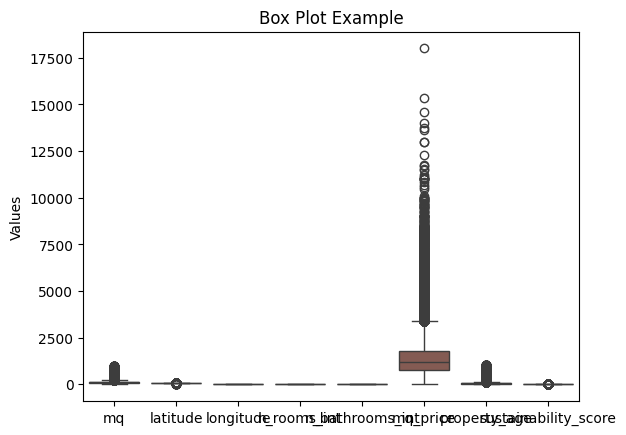

In [13]:
data = cleaned_data.select_dtypes(include=[float, int])
data = data.drop(columns=['price', 'year_of_construction', 'added_commodity_weight'])
# Create the box plot
sns.boxplot(data=data)

# Add title and labels
plt.title('Box Plot Example')
plt.ylabel('Values')

# Display the plot
plt.show()

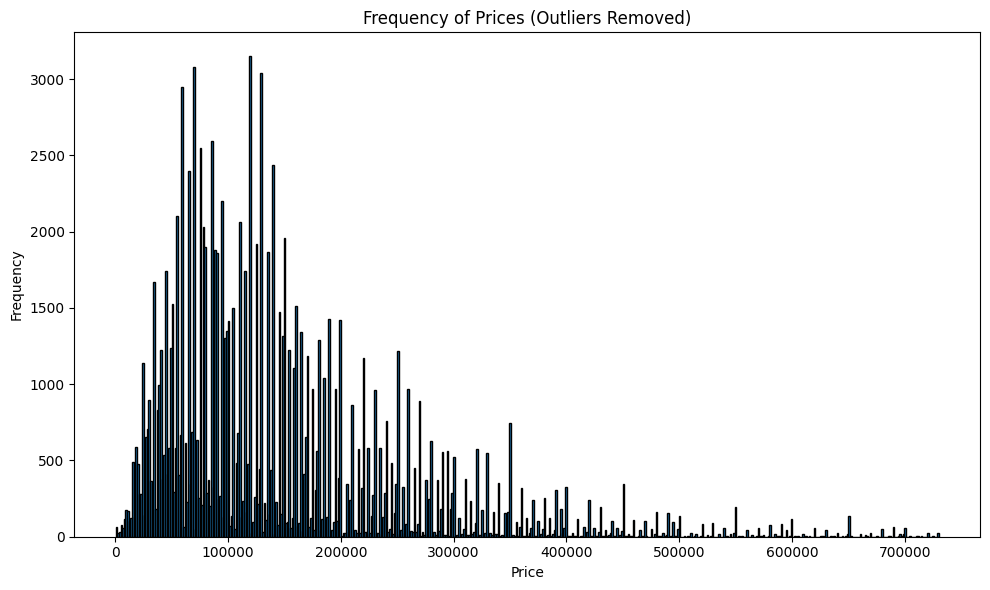

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(cleaned_data['price'], bins=500, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Frequency of Prices (Outliers Removed)')
plt.tight_layout()
plt.show()

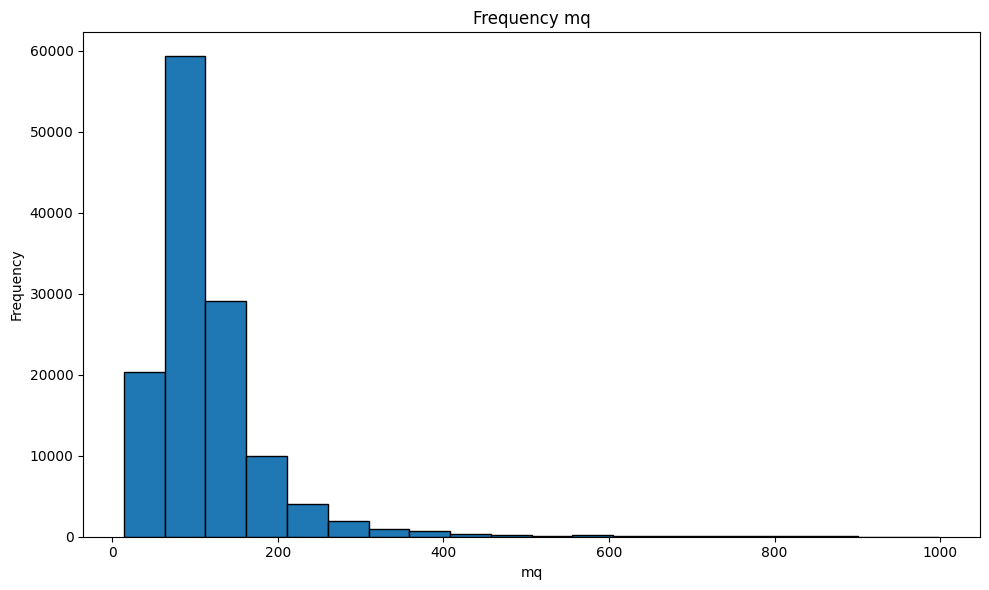

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(cleaned_data['mq'], bins=20, edgecolor='black')
plt.xlabel('mq')
plt.ylabel('Frequency')
plt.title('Frequency mq')
plt.tight_layout()
plt.show()

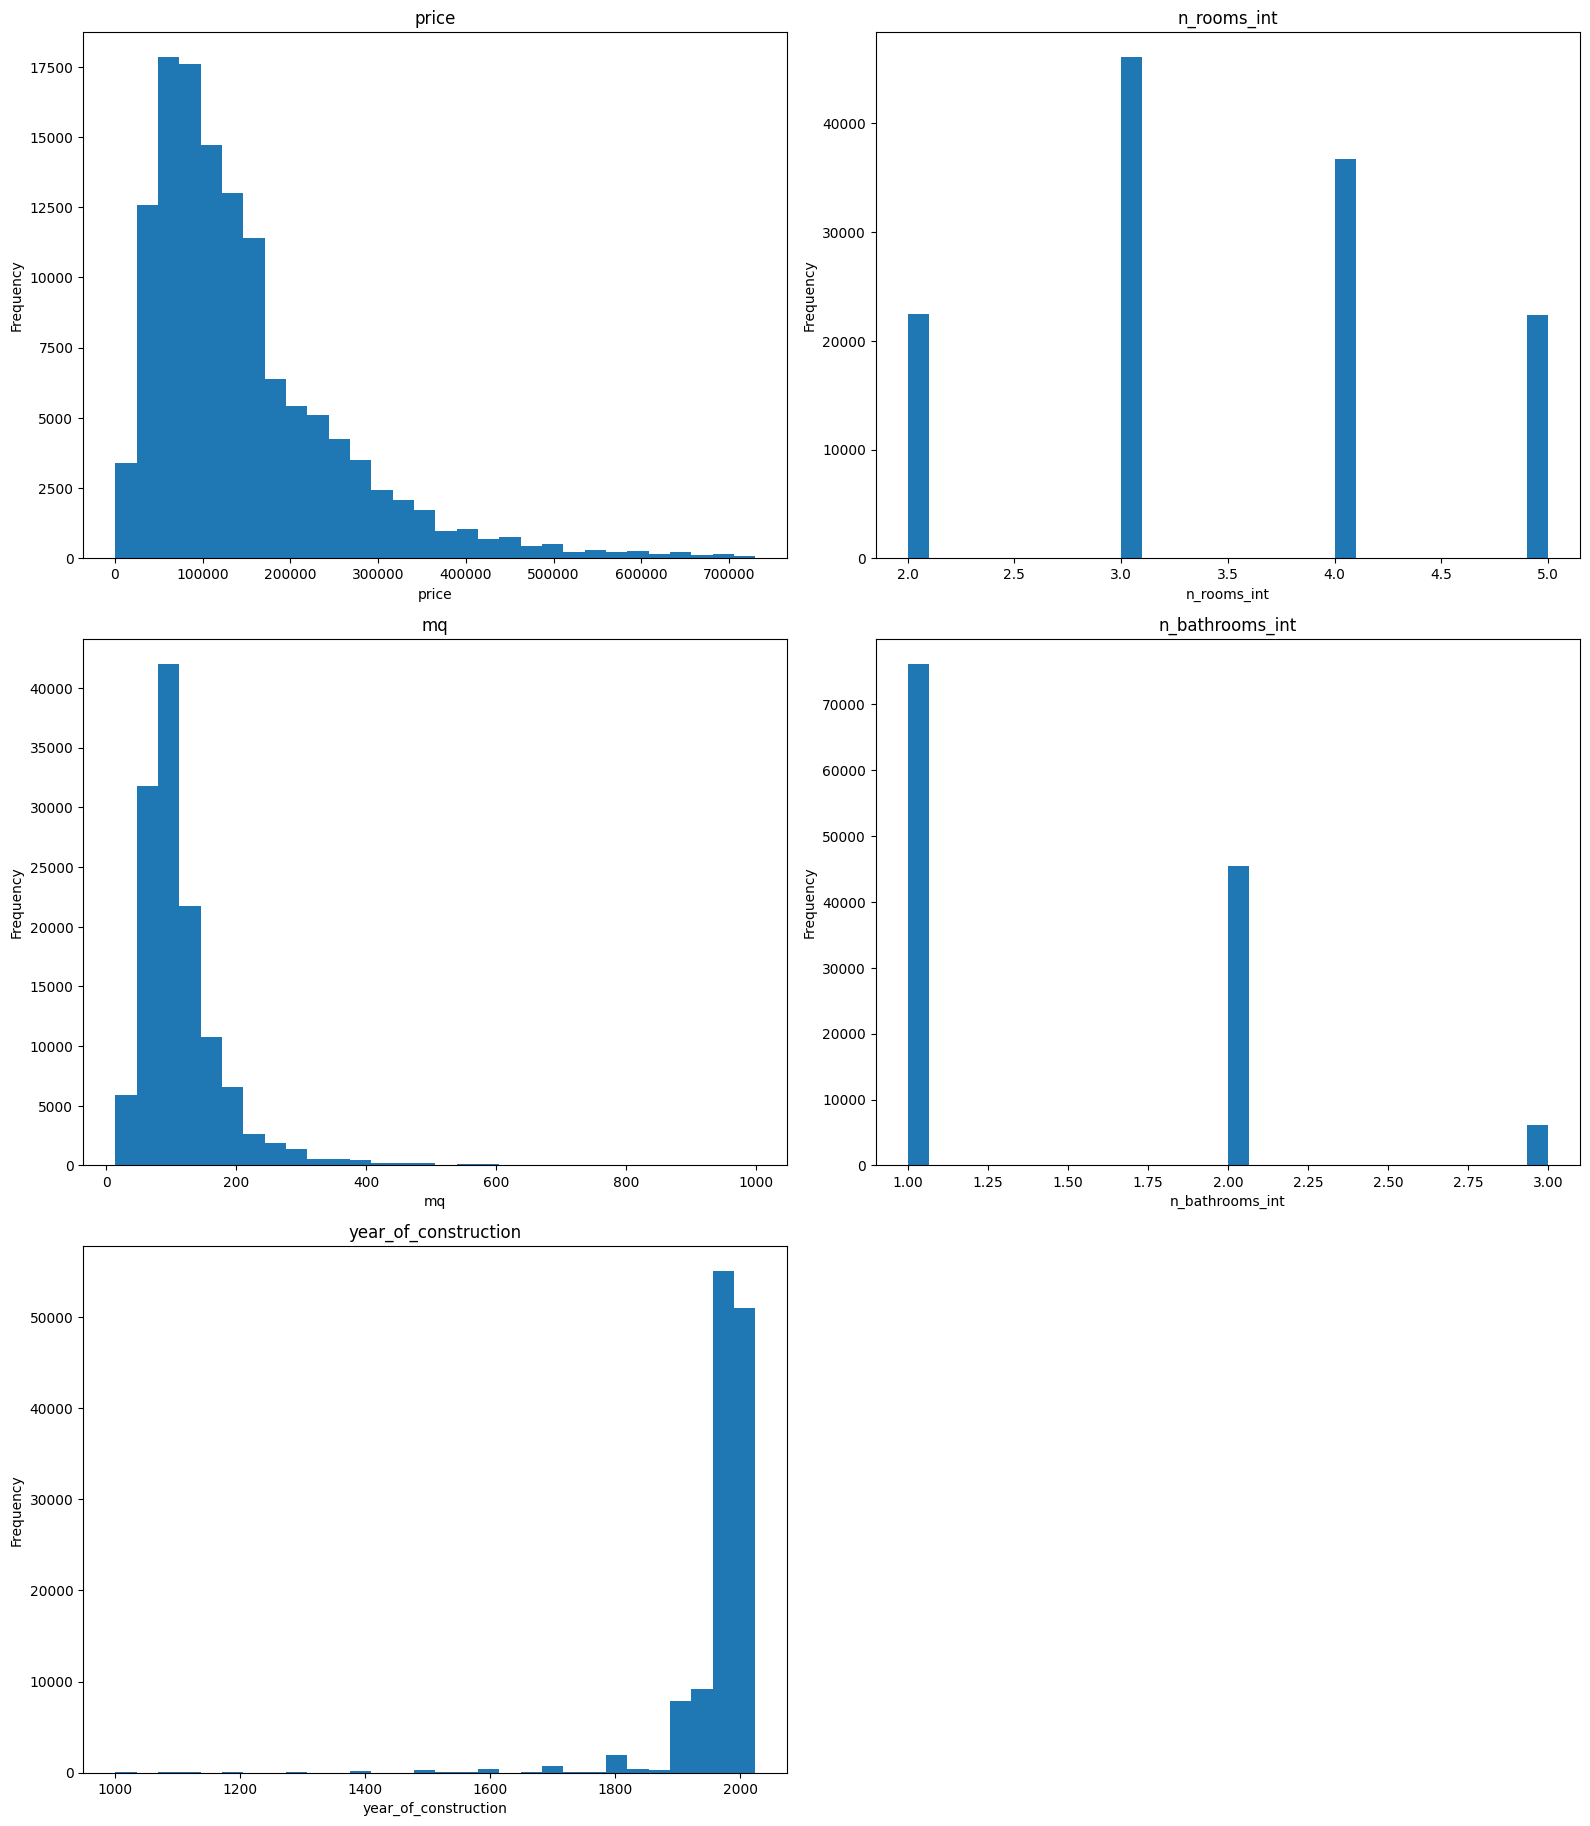

In [16]:
# List of columns to plot, excluding non-numeric columns
#'latitude', 'longitude'
columns_to_plot = ['price', 'n_rooms_int', 'mq', 'n_bathrooms_int', 'year_of_construction']

# Set up the plotting area
plt.figure(figsize=(16, 24))

# Plot each numeric column in a separate subplot
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, i)  # 4 rows, 2 columns for subplots
    cleaned_data[column].plot(kind='hist', bins=30, title=column)
    plt.xlabel(column)

# Show the plots
plt.tight_layout()
plt.show()

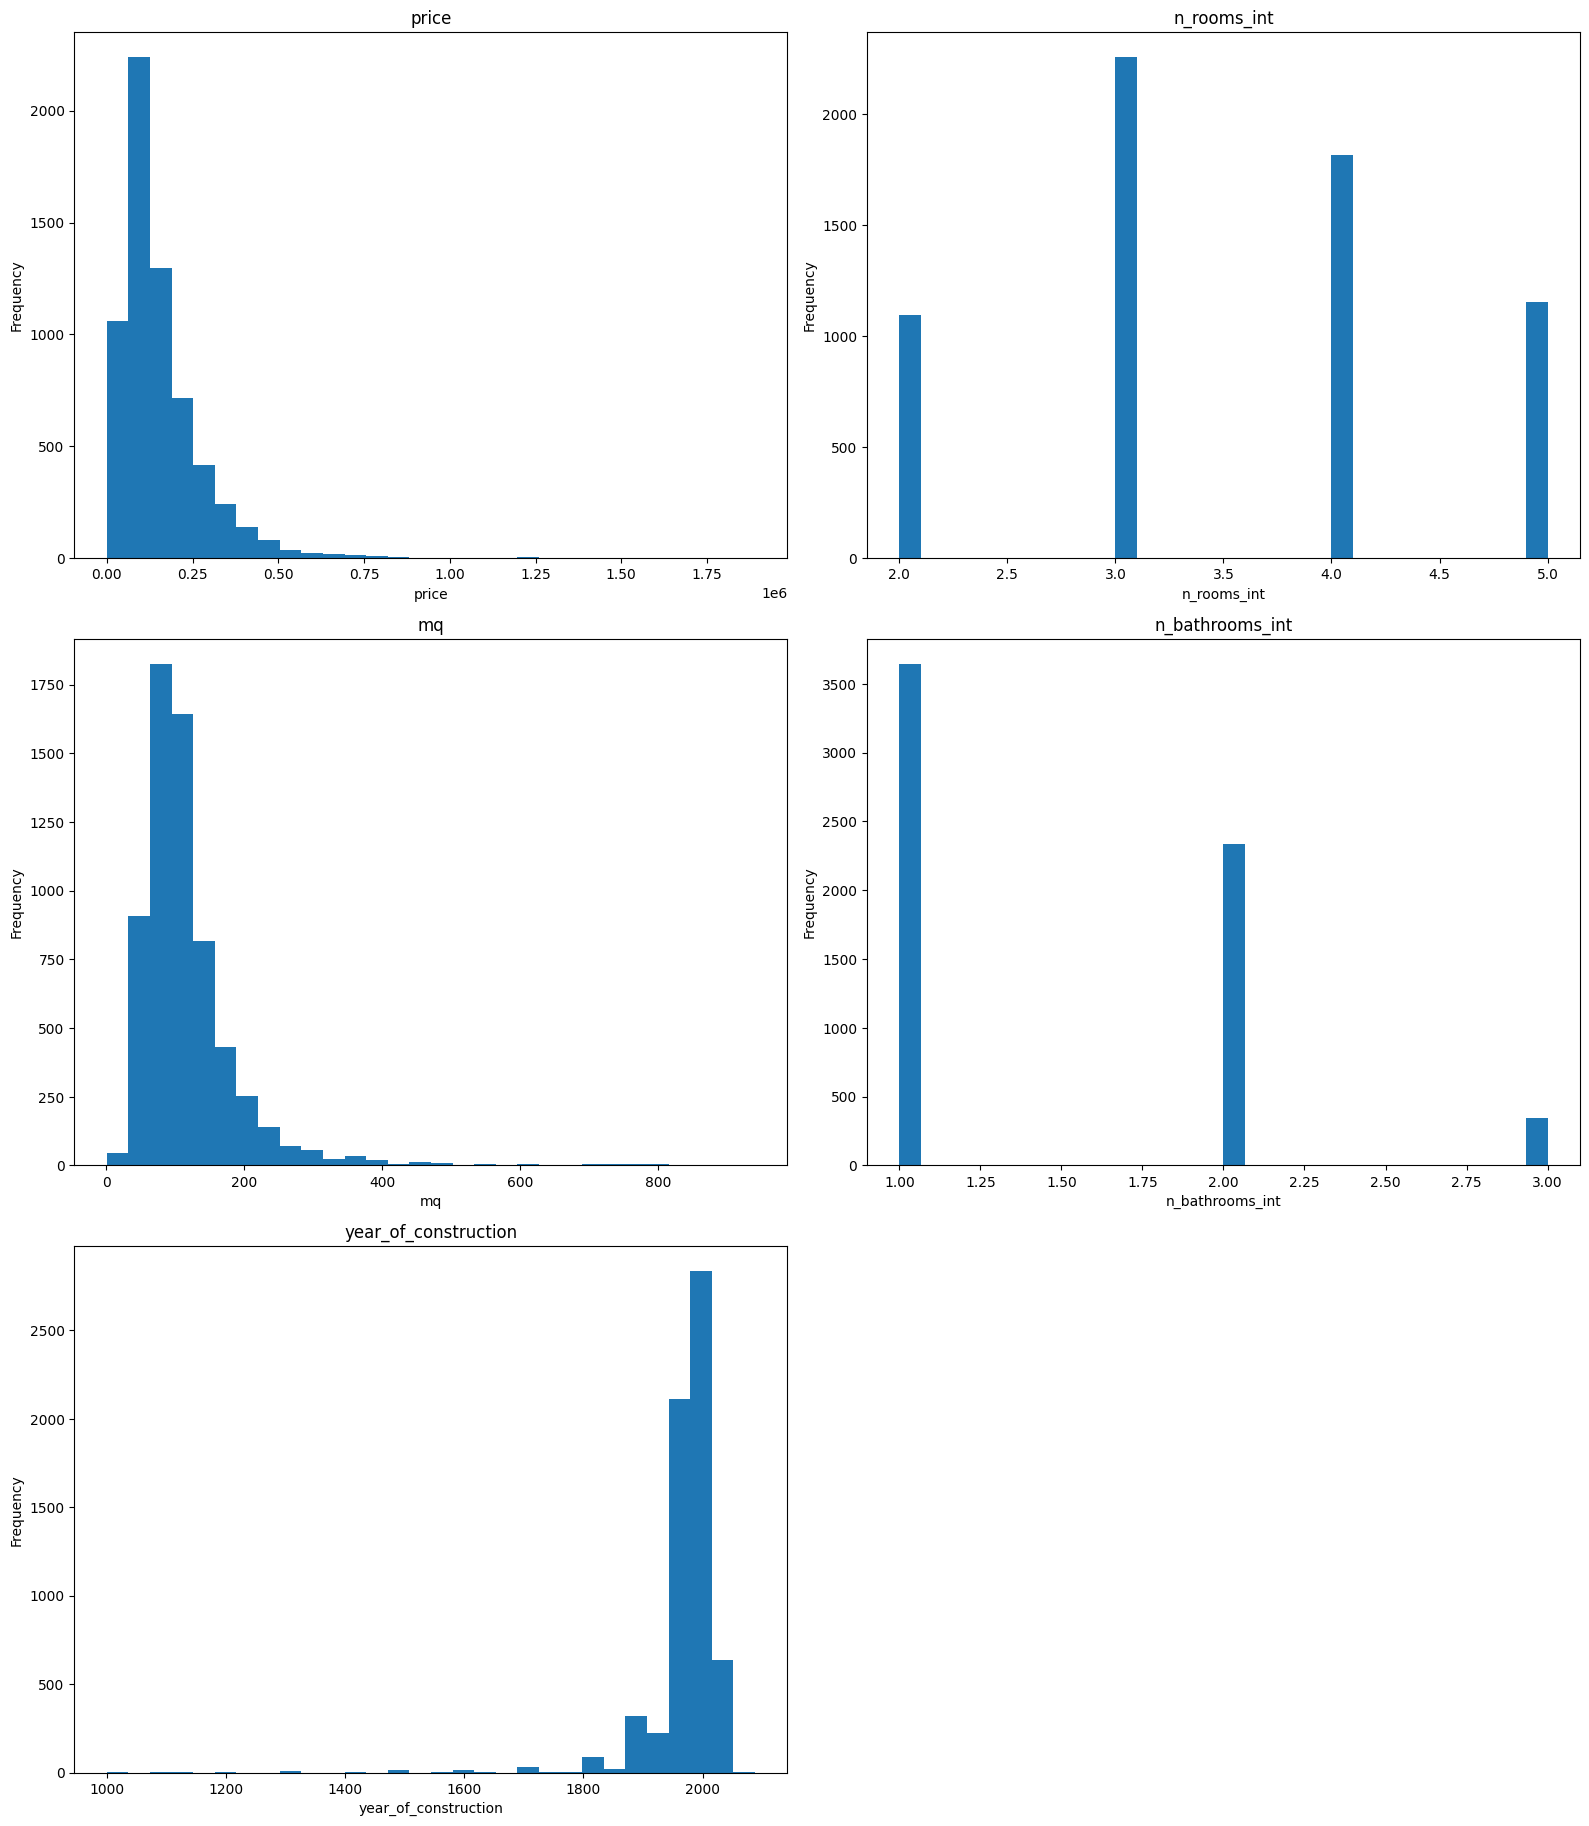

In [17]:
# List of columns to plot, excluding non-numeric columns
#'latitude', 'longitude'
columns_to_plot = ['price', 'n_rooms_int', 'mq', 'n_bathrooms_int', 'year_of_construction']

# Set up the plotting area
plt.figure(figsize=(16, 24))

# Plot each numeric column in a separate subplot
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, i)  # 4 rows, 2 columns for subplots
    df_test[column].plot(kind='hist', bins=30, title=column)
    plt.xlabel(column)

# Show the plots
plt.tight_layout()
plt.show()

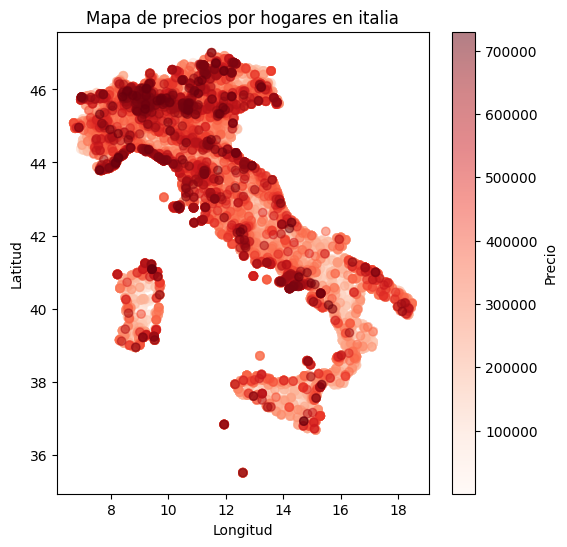

In [18]:
data_geo = cleaned_data[['latitude', 'longitude', 'price']].dropna()
#data_geo = data_geo[data_geo['longitude'] <= 50]
data_geo = data_geo.sort_values(by='price', ascending=True)
plt.figure(figsize=(6, 6))
plt.scatter(data_geo['longitude'], data_geo['latitude'], alpha=0.5, c=data_geo['price'], cmap='Reds')

plt.title('Mapa de precios por hogares en italia')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar(label='Precio')
plt.show()

Se puede observar de manera general que a ma hay areas de concentracion donde las propiedades de alto valor se juntan

# Seleccion de caracteristicas (manual)

Primero creare una matriz de correlacion para ver que caracteristicas que podriamos usar para la seleccion.

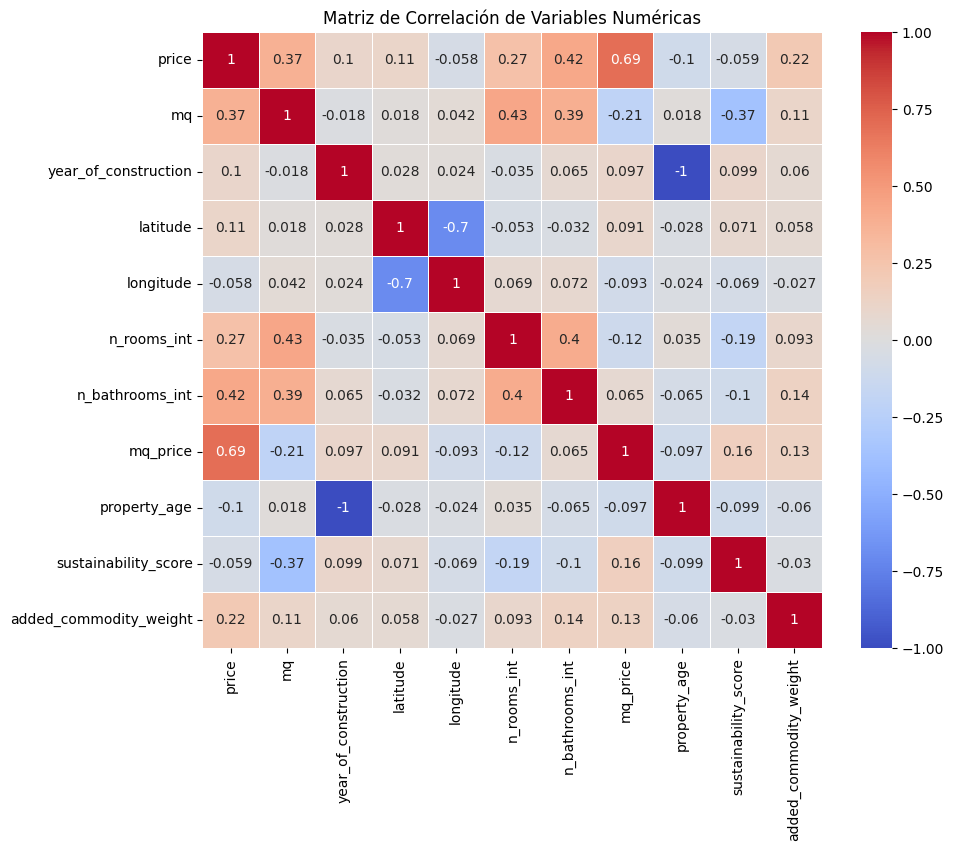

In [19]:

numeric_columns = cleaned_data.select_dtypes(include=[float, int])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

In [20]:
missing_data = cleaned_data.isnull().sum()
print(missing_data)
missing_data = df_test.isnull().sum()
print(missing_data)

location                     0
price                        0
mq                           0
year_of_construction         0
availability                 0
energy_class                 0
status                       0
latitude                     0
longitude                    0
n_rooms_int                  0
n_bathrooms_int              0
has_garage_bool              0
has_terrace_bool             0
has_garden_bool              0
has_balcony_bool             0
has_fireplace_bool           0
has_alarm_bool               0
has_air_conditioning_bool    0
has_pool_bool                0
has_parking_bool             0
has_elevator_bool            0
is_furnished_bool            0
timestamp_dt                 0
mq_price                     0
property_age                 0
sustainability_score         0
added_commodity_weight       0
dtype: int64
location                     0
price                        0
mq                           0
year_of_construction         0
availability              

Mean Squared Error: 13253495883.913246
R-squared: 0.2288056936536228


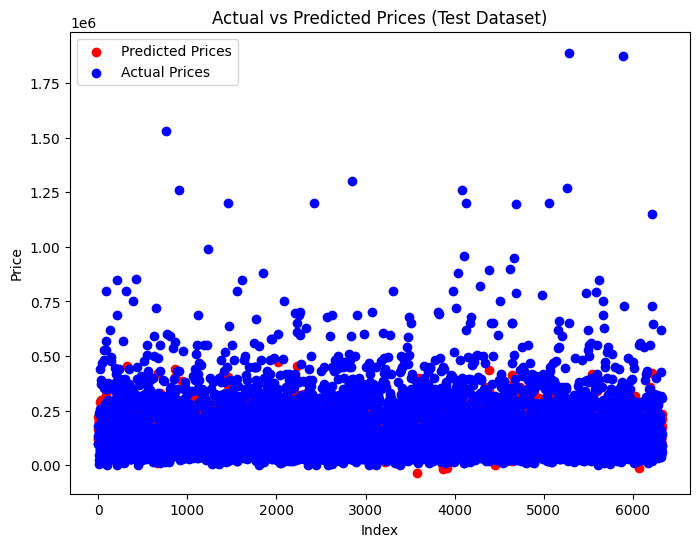

In [21]:

X_train = cleaned_data[['mq','n_rooms_int','n_bathrooms_int','year_of_construction', 'latitude', 'longitude']]  # Example independent variables
y_train = cleaned_data['price']


X_test = df_test[['mq','n_rooms_int','n_bathrooms_int','year_of_construction', 'latitude', 'longitude']]  # Same features as training data
y_test = df_test['price']

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

plt.figure(figsize=(8, 6))

#Plot
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Prices')
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (Test Dataset)')
plt.legend()

plt.show()

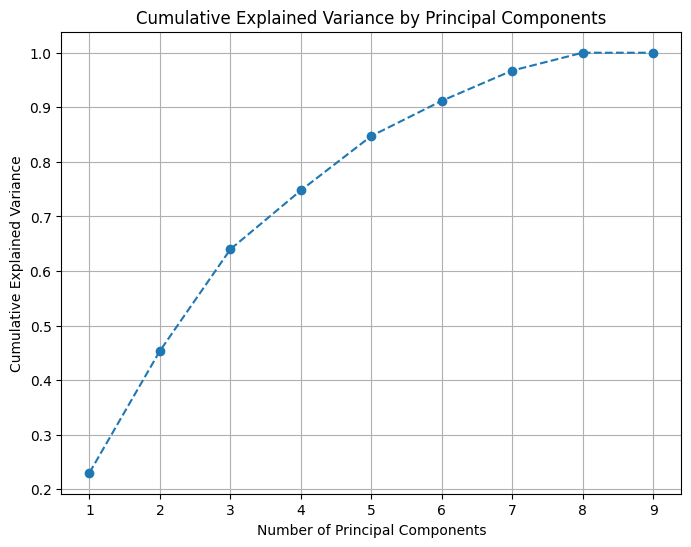

In [22]:

numeric_columns = cleaned_data.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_columns)

pca = PCA(n_components=len(numeric_columns.columns))
pca_result = pca.fit_transform(scaled_data)

explained_variance = pca.explained_variance_ratio_.cumsum()

#Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


(127606, 7)
(6327, 7)
Mean Squared Error: 12845599592.76796
R-squared: 0.2525403595912993


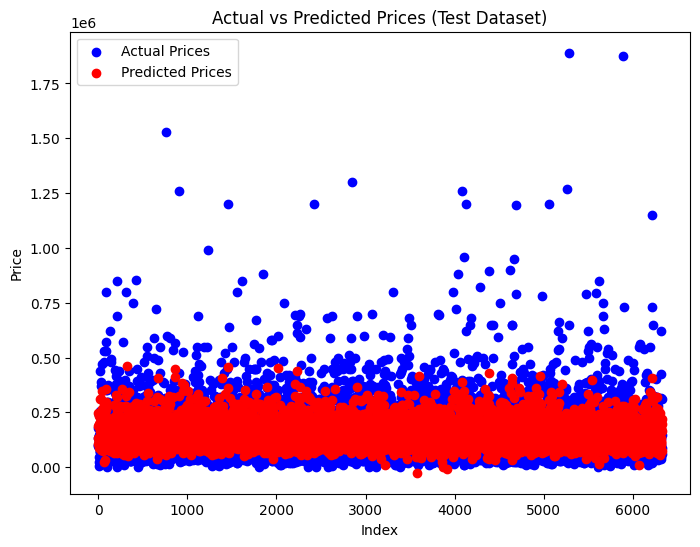

In [23]:
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(scaled_data)

print(reduced_data.shape)

scaled_test_data = scaler.transform(df_test.select_dtypes(include=[float, int]).drop(columns=['price','mq_price']))
reduced_test_data = pca.transform(scaled_test_data)
print(reduced_test_data.shape)

x_train = reduced_data
y_train = cleaned_data['price']
y_test = df_test['price']

model = LinearRegression()
model.fit(x_train, y_train)

y_test_pred = model.predict(reduced_test_data)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


plt.figure(figsize=(8, 6))

# Plot
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Prices')
plt.scatter(range(len(y_test_pred)), y_test_pred, color='red', label='Predicted Prices')

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (Test Dataset)')
plt.legend()

plt.show()

Grafica del PCA

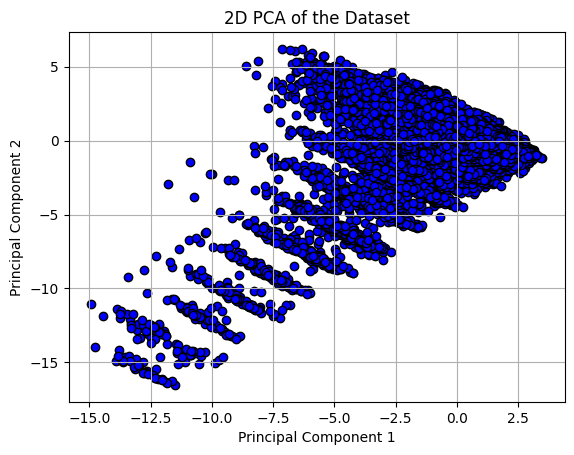

In [24]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', edgecolor='k')
plt.title('2D PCA of the Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True) 
plt.show()

# Seleccion de caracteristicas

In [ ]:

X = cleaned_data.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])
y = cleaned_data['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=100)
rfe = RFE(model, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print("Selected features using RFE:", selected_features)

Output:
/Users/jorgemagdaleno/PycharmProjects/pythonProject/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jorgemagdaleno/PycharmProjects/pythonProject/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Selected features using RFE: Index(['mq', 'latitude', 'n_bathrooms_int', 'property_age', 'sustainability_score'],
      dtype='object')

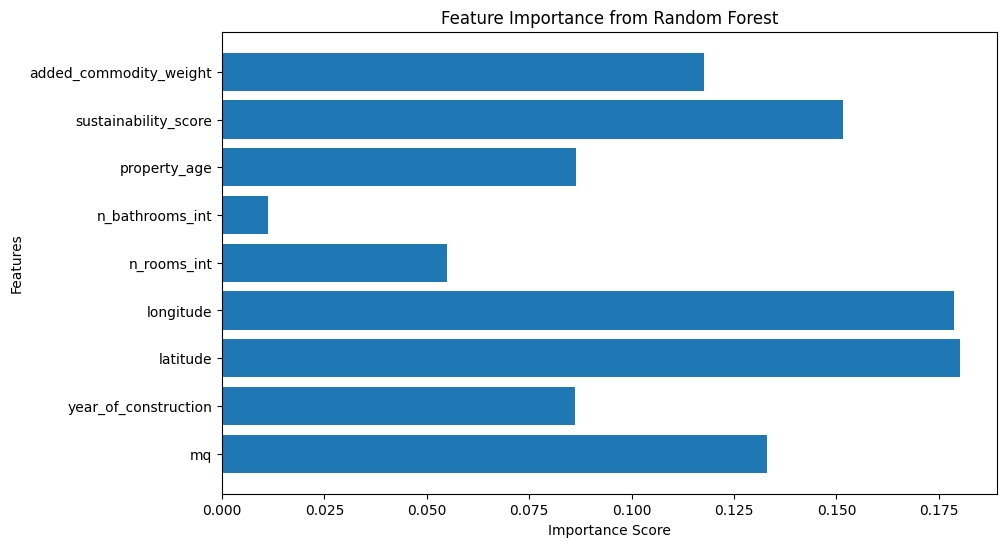

Features ranked by importance: latitude                  0.180185
longitude                 0.178639
sustainability_score      0.151573
mq                        0.133096
added_commodity_weight    0.117744
property_age              0.086434
year_of_construction      0.086123
n_rooms_int               0.054945
n_bathrooms_int           0.011262
dtype: float64


In [24]:

X = cleaned_data.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])
y = cleaned_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.show()

feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("Features ranked by importance:", feature_importance)

# Modelos de regresion (Contra data de entrenamiento)

Aparte del que ya se mostro anteriormente de regresion lineal aqui se probaran otros modelos

Decision Tree Regression

In [27]:
X = cleaned_data.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])
y = cleaned_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 9927822529.780722
R-squared: 0.1813625559939901


Random Forest Regression

In [28]:
X = cleaned_data.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])
y = cleaned_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 5136107580.322977
R-squared: 0.5764821571817156


Support Vector Regression (SVR)

In [29]:
X = cleaned_data.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])
y = cleaned_data['price']

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

model = SVR(kernel='rbf')
model.fit(X_train, y_train.ravel())

y_pred = model.predict(X_test)
y_pred_unscaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred_unscaled)
r2 = r2_score(scaler_y.inverse_transform(y_test), y_pred_unscaled)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 7730782937.647605
R-squared: 0.36252805030944746


# Modelos de regresion (Contra data de prueba)

Decision Tree Regression

In [30]:
X_train = cleaned_data.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])
y_train = cleaned_data['price']

X_test = df_test.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])
y_test = df_test['price']


model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 12834322941.02717
R-squared: 0.2531965253073729


Random Forest Regression

In [31]:
X_train = cleaned_data.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])
y_train = cleaned_data['price']

X_test = df_test.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])
y_test = df_test['price']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 8007384980.470626
R-squared: 0.5340663505122597


Support Vector Regression (SVR)

In [32]:
X = cleaned_data.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])
y = cleaned_data['price']
X_test = df_test.select_dtypes(include=[float, int]).drop(columns=['price','mq_price'])
y_test = df_test['price']


scaler_X_train = StandardScaler()
scaler_y_train = StandardScaler()
scaler_X_test = StandardScaler()
scaler_y_test = StandardScaler()

X_scaled = scaler_X_train.fit_transform(X)
y_scaled = scaler_y_train.fit_transform(y.values.reshape(-1, 1))
X_scaled_test = scaler_X_test.fit_transform(X_test)
y_scaled_test = scaler_y_test.fit_transform(y_test.values.reshape(-1, 1))

X_train = X_scaled
X_test = X_scaled_test
y_train = y_scaled
y_test = y_scaled_test

model = SVR(kernel='rbf')
model.fit(X_train, y_train.ravel())

y_pred = model.predict(X_test)
y_pred_unscaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred_unscaled)
r2 = r2_score(scaler_y.inverse_transform(y_test), y_pred_unscaled)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 7904795683.291441
R-squared: 0.3398672681283289


Conclusión:

Después de analizar el dataset de propiedades en Italia, probé varias técnicas para seleccionar características y diferentes modelos de regresión para predecir los precios. Entre las técnicas de selección de características, la que mejor funcionó fue la de importancia de características usando Random Forest, ya que identificó las variables clave. También probé métodos como RFE, pero en algunos casos tuve que ajustar los parámetros o escalar los datos para que el modelo convergiera correctamente.

En cuanto a los modelos de regresión, utilicé varios, como Decision Tree Regression, Support Vector Regression (SVR) y Random Forest Regression. Finalmente, el que mejor rendimiento tuvo fue Random Forest Regression.

Con los datos reales, este modelo me dio los siguientes resultados:

- Mean Squared Error (MSE): 8007384980.470626
- R-squared: 0.5340663505122597

Estos resultados indican que el modelo fue capaz de capturar algo más de la mitad de la variabilidad en los precios de las propiedades, aunque todavía queda margen para mejorar la precisión. Factores como la complejidad de las propiedades y los datos faltantes en algunas características (como el año de construcción) probablemente influyeron en los resultados. Además, aspectos como la energy_class también resultaron útiles para ajustar el modelo.

En resumen, el modelo Random Forest Regression fue el que mejor se ajustó a este dataset, logrando un buen balance entre la complejidad y la precisión al predecir los precios de las propiedades con la información disponible.